<a href="https://colab.research.google.com/github/rororoy/Assembler-Project/blob/main/Model%20Comparison%3A%20Perceptron%20Logistic%20and%20Linear%20Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MMN 11 - ROY LAVROV - 322492059**
## **Handwritten Digit Classification**
### As stated in the guidelines the task is to train  our model on datasets of handwritten digits (0-9) to guess for an image the apropriate digit it represents.


---


### **Setting up and preperations:**

Importing usefull packages:


In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

> The MNIST dataset serves as a cornerstone in the domain of digit classification. It
comprises a collection of 28x28 pixel grayscale images, each depicting a handwritten
digit (0 through 9).



The training MNIST dataset split into two subsets of images:
* **60,000** - for training
* **10,000** - for testing

In [ ]:
# Fetch MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

samples = X.shape[0]
features = X.shape[1]

# Convert X into a matrix with bias (=1)
X = X.to_numpy()
X_with_bias = np.c_[X, np.ones(X.shape[0])]

# Convert string labels to integers
y = y.astype(int)

# Convert y into a matrix
y = y.to_numpy()

# Convert y into a matrix of one hot vectors
y_onehot = np.zeros((samples, 10), dtype=int)
y_onehot[np.arange(samples), y] = 1

# Split into training and testing sets (60,000 for training, 10,000 for testing)
X_train, X_test, y_train_onehot, y_test_onehot = train_test_split(
    X_with_bias, y_onehot, train_size=60000, test_size=10000, random_state=42)

# Crearing a signed y set with values [-1,1]
y_signed_train = np.where(y_train_onehot == 1, 1, -1)
y_signed_test = np.where(y_test_onehot == 1, 1, -1)

### **Utils**

In [41]:
def compare_models(binary_metrics, multiclass_metrics):
  """Compare binary and multiclass perceptron performances with aligned visualizations."""
  metrics = ['Accuracy', 'Sensitivity', 'Selectivity']

  # Prepare data for comparison
  binary_avgs = [np.mean(binary_metrics[metric]) for metric in metrics]
  multi_avgs = [np.mean(multiclass_metrics[metric]) for metric in metrics]

  # Set consistent figure size for both visualizations
  fig_width = 12

  # Create bar chart
  plt.figure(figsize=(fig_width, 6))

  x = np.arange(len(metrics))
  width = 0.35

  plt.bar(x - width/2, binary_avgs, width, label='Individual Perceptrons (Avg)')
  plt.bar(x + width/2, multi_avgs, width, label='MultiClass Perceptron')

  plt.xlabel('Metric')
  plt.ylabel('Score')
  plt.title('Performance Comparison: Individual vs. MultiClass Perceptrons')
  plt.xticks(x, metrics)
  plt.ylim(0, 1)
  plt.legend()
  plt.grid(axis='y', linestyle='--', alpha=0.7)

  # Add value annotations
  for i, v in enumerate(binary_avgs):
    plt.text(i - width/2, v + 0.02, f'{v:.4f}', ha='center')

  for i, v in enumerate(multi_avgs):
    plt.text(i + width/2, v + 0.02, f'{v:.4f}', ha='center')

  plt.tight_layout()
  plt.show()

  # Create table visualization with the same width
  fig, ax = plt.subplots(figsize=(fig_width, 3))
  ax.axis('off')
  ax.axis('tight')

  table_data = [
      ['Metric', 'Individual Perceptrons (Avg)', 'MultiClass Perceptron', 'Difference'],
  ]

  for i, metric in enumerate(metrics):
    diff = binary_avgs[i] - multi_avgs[i]
    table_data.append([
      metric,
      f'{binary_avgs[i]:.4f}',
      f'{multi_avgs[i]:.4f}',
      f'{diff:.4f}'
    ])

  table = ax.table(cellText=table_data, loc='center', cellLoc='center')
  table.auto_set_font_size(False)
  table.set_fontsize(12)
  table.scale(1, 1.5)

  # Style the header row
  for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(color='white')

  plt.title('Performance Metrics Comparison', y=0.8, fontsize=14)
  plt.tight_layout()
  plt.show()


def analyze_classification_performance(model, X_test, y_test_onehot):
    """
    Analyze the classification performance of a trained model with per-digit confusion matrices.
    All visualizations use wider canvas sizes with proper spacing.
    """
    # Define standard figure width for consistency - increased for larger display
    std_width = 16  # Increased from 12 to 16

    # Compute predictions
    y_pred = model.predict(X_test)
    y_true = np.argmax(y_test_onehot, axis=1)

    # Compute confusion matrix
    conf_matrix = model.compute_confusion_matrix(X_test, y_test_onehot)

    # Get metrics
    metrics = model.compute_metrics(conf_matrix)
    overall_accuracy = metrics['accuracy']

    # Ensure sensitivity is an array
    if isinstance(metrics['sensitivity'], (float, np.float64)):
        # If sensitivity is a single value, create an array
        class_sensitivity = np.zeros(10)
        class_sensitivity.fill(metrics['sensitivity'])
    else:
        # Use the array as provided
        class_sensitivity = metrics['sensitivity']

    # Print overall accuracy
    print(f"Overall Accuracy: {overall_accuracy:.4f}")

    # Calculate accuracy for each digit
    digit_accuracies = np.zeros(10)
    for i in range(10):
        # True positives / all samples of this digit
        if np.sum(conf_matrix[i, :]) > 0:  # Avoid division by zero
            digit_accuracies[i] = conf_matrix[i, i] / np.sum(conf_matrix[i, :])

    # Print class-wise accuracy
    print("\nAccuracy for each digit:")
    for digit in range(10):
        print(f"Digit {digit}: {digit_accuracies[digit]:.4f}")

    # Print class-wise sensitivity (TPR)
    print("\nSensitivity (TPR) for each digit:")
    for digit in range(10):
        print(f"Digit {digit}: {class_sensitivity[digit]:.4f}")

    # Calculate precision for each class
    precision = np.zeros(10)
    for i in range(10):
        if np.sum(conf_matrix[:, i]) > 0:  # Avoid division by zero
            precision[i] = conf_matrix[i, i] / np.sum(conf_matrix[:, i])

    # Print precision values
    print("\nPrecision for each digit:")
    for digit in range(10):
        print(f"Digit {digit}: {precision[digit]:.4f}")

    # ===== Visualization section =====

    # 1. Overall Confusion Matrix Heatmap
    plt.figure(figsize=(std_width, std_width))
    sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues',
                xticklabels=range(10),
                yticklabels=range(10))
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Overall Confusion Matrix', pad=20, fontsize=16)  # Added padding
    plt.tight_layout()
    plt.show()

    # 2. Individual digit confusion matrices (binary: one vs all)
    # Create a 2x5 grid (2 rows, 5 columns) for perfect alignment of 10 digits
    fig, axes = plt.subplots(2, 5, figsize=(std_width, std_width/2))
    axes = axes.flatten()

    for digit in range(10):
        ax = axes[digit]

        # Create binary confusion matrix for this digit
        binary_cm = np.zeros((2, 2))
        # True positive: correctly identified as this digit
        binary_cm[0, 0] = conf_matrix[digit, digit]
        # False negative: is this digit but predicted as another
        binary_cm[0, 1] = np.sum(conf_matrix[digit, :]) - conf_matrix[digit, digit]
        # False positive: is another digit but predicted as this one
        binary_cm[1, 0] = np.sum(conf_matrix[:, digit]) - conf_matrix[digit, digit]
        # True negative: correctly identified as not this digit
        binary_cm[1, 1] = np.sum(conf_matrix) - binary_cm[0, 0] - binary_cm[0, 1] - binary_cm[1, 0]

        # Plot the binary confusion matrix
        labels = [f'Is {digit}', f'Not {digit}']  # Shorter labels for better fit
        sns.heatmap(binary_cm, annot=True, fmt='.0f', cmap='Blues', ax=ax,
                    xticklabels=labels, yticklabels=labels)

        # Calculate digit-specific metrics
        digit_acc = (binary_cm[0, 0] + binary_cm[1, 1]) / np.sum(binary_cm)
        digit_sens = binary_cm[0, 0] / (binary_cm[0, 0] + binary_cm[0, 1]) if (binary_cm[0, 0] + binary_cm[0, 1]) > 0 else 0
        digit_prec = binary_cm[0, 0] / (binary_cm[0, 0] + binary_cm[1, 0]) if (binary_cm[0, 0] + binary_cm[1, 0]) > 0 else 0

        ax.set_title(f'Digit {digit}\nAcc: {digit_acc:.4f}, TPR: {digit_sens:.4f}', fontsize=10)

    # Adjust spacing and layout
    plt.tight_layout()

    # Add a main title with proper spacing
    fig.subplots_adjust(top=0.85)  # Make room for the title
    plt.suptitle('Per-Digit Confusion Matrices (One-vs-All)', fontsize=16, y=0.98)
    plt.show()

    # 3. Per-class metrics visualization - Now wider to show more detail
    plt.figure(figsize=(std_width, std_width/2.5))

    x = np.arange(10)
    width = 0.3  # Slightly narrower bars

    # Plot accuracy, sensitivity and precision for each class
    plt.bar(x - width, digit_accuracies, width, label='Accuracy', color='#3498db')
    plt.bar(x, class_sensitivity, width, label='Sensitivity', color='#2ecc71')
    plt.bar(x + width, precision, width, label='Precision', color='#e74c3c')

    # Add value labels on top of each bar
    for i, v in enumerate(digit_accuracies):
        plt.text(i - width, v + 0.01, f'{v:.4f}', ha='center', fontsize=9, rotation=90)

    for i, v in enumerate(class_sensitivity):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=9, rotation=90)

    for i, v in enumerate(precision):
        plt.text(i + width, v + 0.01, f'{v:.4f}', ha='center', fontsize=9, rotation=90)

    plt.title('Per-Digit Classification Performance', pad=20, fontsize=16)
    plt.xlabel('Digit', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(x, [str(i) for i in range(10)], fontsize=12)
    plt.ylim(0, 1.1)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': overall_accuracy,
        'digit_accuracies': digit_accuracies,
        'sensitivity': class_sensitivity,
        'precision': precision,
        'confusion_matrix': conf_matrix
    }

# **Part A: Perceptron**
### **We define the single Perceptron class that will be trained individually to correctly predict a given target digit as one vs all.**
* We track the history of the best performing weights (starting with W = 0) to track the one with the best accurecy one as per the pocket algorithem
* The model determines the better weight to use based on what the error rate is by calculating the proportion of examples that were misclassified

In [ ]:
class Perceptron:
  def __init__(self, n_features=785, target_digit=None, max_iterations=1000, learning_rate=1.0):
    self.n_features = n_features
    self.target_digit = target_digit
    self.max_iterations = max_iterations
    self.learning_rate = learning_rate
    self.W = None
    self.pocket_history = []

  def fit(self, X, y_signed):
    # Extract relevant column for this perceptron's target digit
    y = y_signed[:, self.target_digit]

    # Initialize weights
    self.W = np.zeros(self.n_features)
    best_W = self.W.copy()
    best_error = float('inf')

    for iteration in tqdm(range(self.max_iterations), desc= f'train with pocket algo'):
      # Get current predictions
      y_pred = self.predict(X)

      # Find misclassified examples
      misclassified_indices = np.where(y_pred != y)[0]

      # If no misclassified examples, we're done
      if len(misclassified_indices) == 0:
        print(f"Perceptron for digit {self.target_digit} converged after {iteration+1} iterations!")
        break

      # Randomly choose a misclassified example
      idx = np.random.choice(misclassified_indices)

      # Update weights
      self.W = self.W + self.learning_rate * y[idx] * X[idx]

      # Calculate current error
      current_error = np.mean(self.predict(X) != y)

      # Update pocket weights if improved
      if current_error < best_error:
        best_W = self.W.copy()
        best_error = current_error

        # Record pocket weights and error
        self.pocket_history.append((iteration + 1, best_W.copy(), best_error))

    # Use the best weights found
    self.W = best_W
    return self


  def predict(self, X):
    return np.sign(X @ self.W)

  def confidence_scores(self, X):
    return X @ self.W

  def calculate_accuracy(self, X, y):
    y_pred = self.predict(X)
    return np.mean(y_pred == y)

  def Ein(self, X, y):
    y_pred = self.predict(X)
    return np.mean(y_pred != y)

### **Now to strengthen the case of the weakness of the later multi class percepton we'll train the perceptron individually for each class and analyze the performance digit by digit**
The results of the individual tests and analysis of the average accurecy and sensetivity will point out the efficiency of the models' predictions when we use the perceptron on each digit individually: one digit vs all


=== Training perceptron for digit 0 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9886
Sensitivity (TPR): 0.9278
Selectivity (TNR): 0.9952

=== Training perceptron for digit 1 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9916
Sensitivity (TPR): 0.9566
Selectivity (TNR): 0.9962

=== Training perceptron for digit 2 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9750
Sensitivity (TPR): 0.8687
Selectivity (TNR): 0.9864

=== Training perceptron for digit 3 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9629
Sensitivity (TPR): 0.7631
Selectivity (TNR): 0.9859

=== Training perceptron for digit 4 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9795
Sensitivity (TPR): 0.8940
Selectivity (TNR): 0.9880

=== Training perceptron for digit 5 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9618
Sensitivity (TPR): 0.7321
Selectivity (TNR): 0.9855

=== Training perceptron for digit 6 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9839
Sensitivity (TPR): 0.9053
Selectivity (TNR): 0.9923

=== Training perceptron for digit 7 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9816
Sensitivity (TPR): 0.8749
Selectivity (TNR): 0.9942

=== Training perceptron for digit 8 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9381
Sensitivity (TPR): 0.5181
Selectivity (TNR): 0.9832

=== Training perceptron for digit 9 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9513
Sensitivity (TPR): 0.7500
Selectivity (TNR): 0.9746


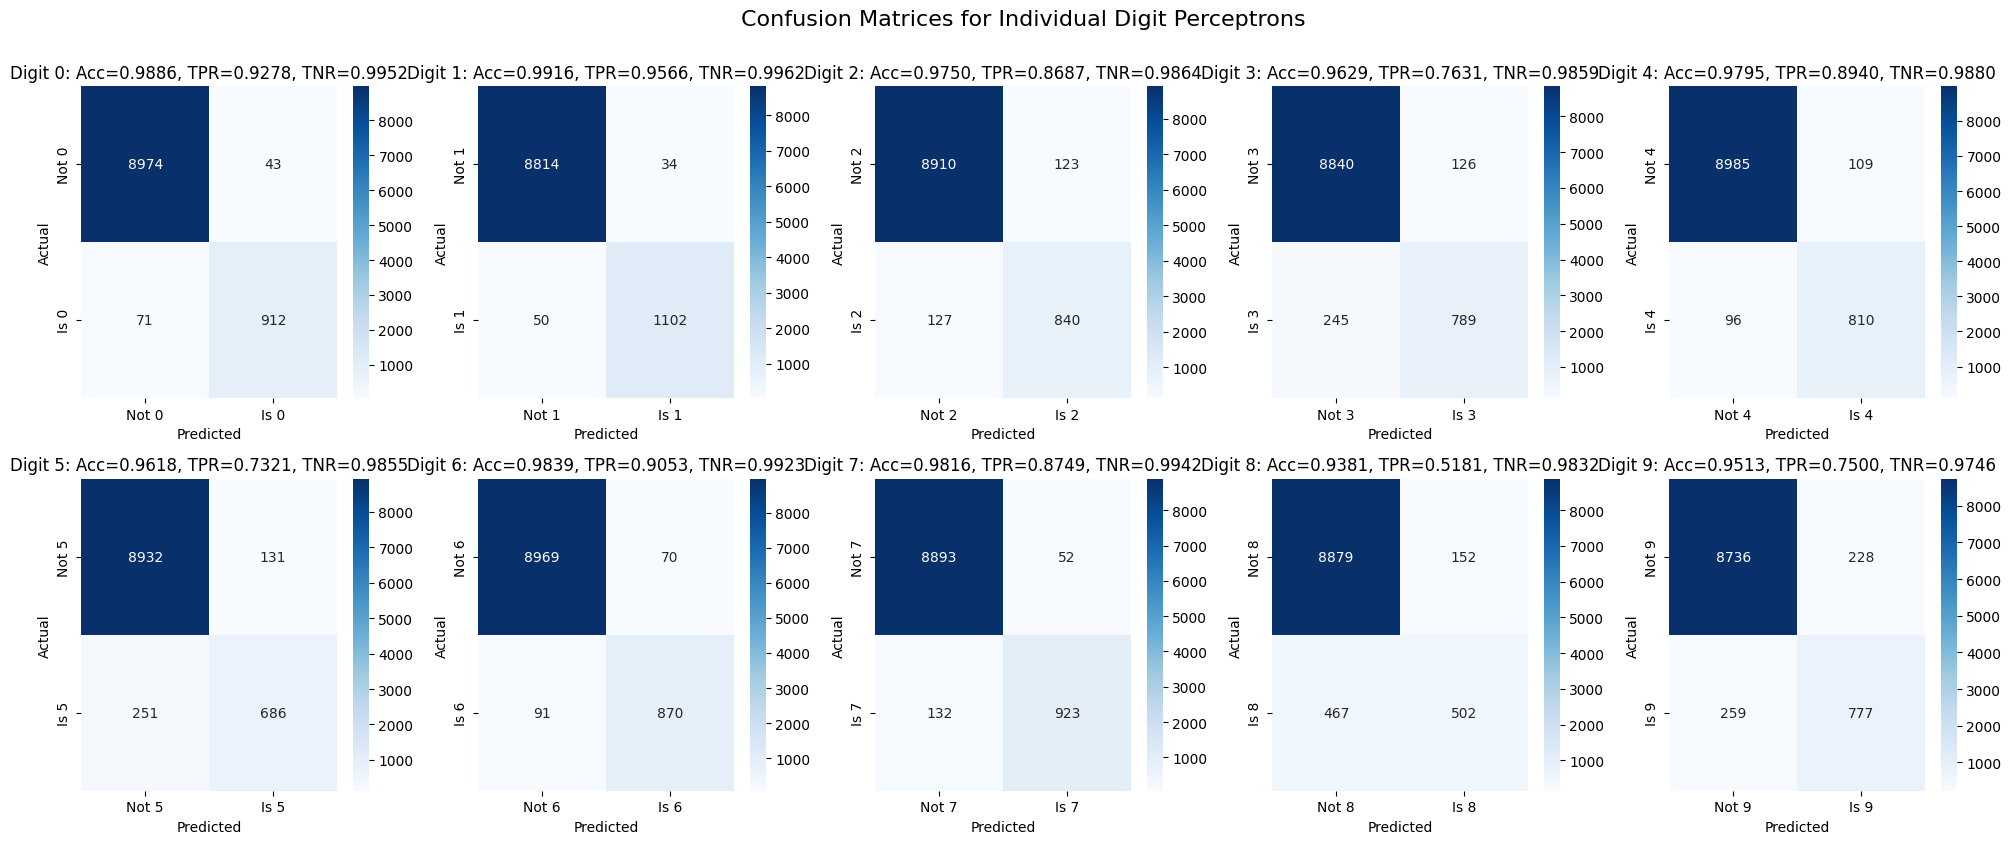

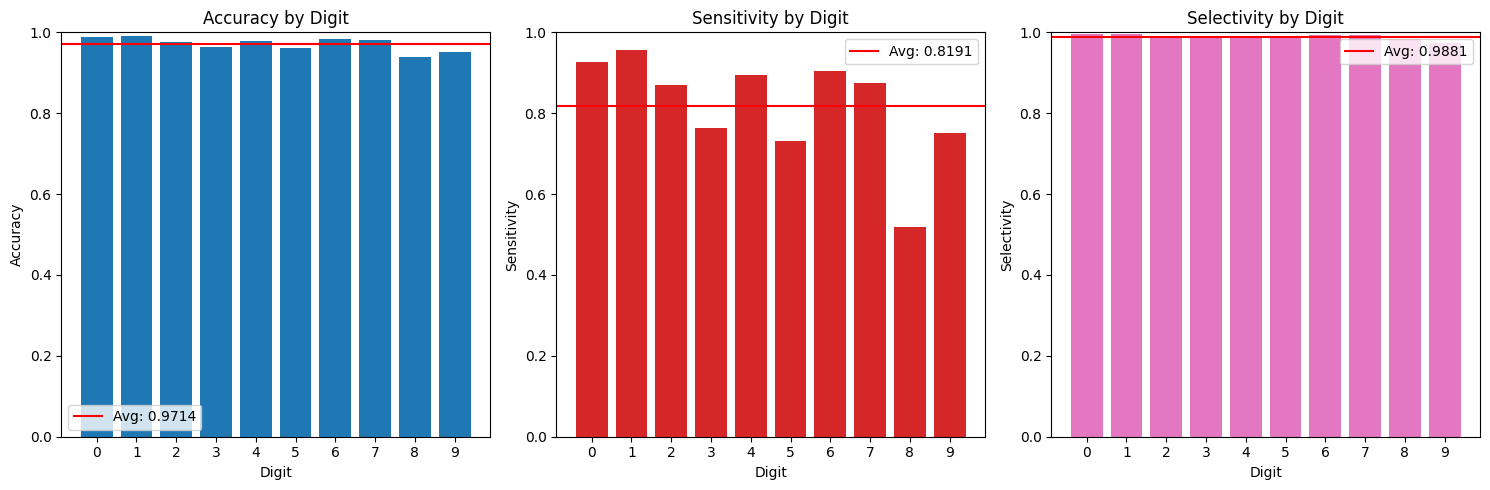


=== Summary ===
Digit  |  Accuracy  |  Sensitivity  |  Selectivity
--------------------------------------------------
  0    |   0.9886   |   0.9278   |   0.9952
  1    |   0.9916   |   0.9566   |   0.9962
  2    |   0.9750   |   0.8687   |   0.9864
  3    |   0.9629   |   0.7631   |   0.9859
  4    |   0.9795   |   0.8940   |   0.9880
  5    |   0.9618   |   0.7321   |   0.9855
  6    |   0.9839   |   0.9053   |   0.9923
  7    |   0.9816   |   0.8749   |   0.9942
  8    |   0.9381   |   0.5181   |   0.9832
  9    |   0.9513   |   0.7500   |   0.9746

Average accuracy: 0.9714
Average sensitivity: 0.8191
Average selectivity: 0.9881


In [ ]:
def train_and_evaluate_all_digits(X_train, y_signed_train, X_test, y_signed_test, max_iterations=700):
    """Train and evaluate individual perceptrons for each digit."""
    # Store results
    accuracies = []
    sensitivities = []
    selectivities = []
    all_conf_matrices = []

    # Train and evaluate a perceptron for each digit
    for digit in range(10):
        print(f"\n=== Training perceptron for digit {digit} ===")

        # Create and train perceptron
        perceptron = Perceptron(n_features=X_train.shape[1], target_digit=digit, max_iterations=max_iterations)
        perceptron.fit(X_train, y_signed_train)

        # Get predictions
        y_pred = perceptron.predict(X_test)
        y_true = y_signed_test[:, digit]

        # Calculate accuracy
        accuracy = np.mean(y_pred == y_true)
        accuracies.append(accuracy)

        # Create confusion matrix
        true_pos = np.sum((y_pred == 1) & (y_true == 1))
        true_neg = np.sum((y_pred == -1) & (y_true == -1))
        false_pos = np.sum((y_pred == 1) & (y_true == -1))
        false_neg = np.sum((y_pred == -1) & (y_true == 1))

        conf_matrix = np.array([
            [true_neg, false_pos],
            [false_neg, true_pos]
        ])
        all_conf_matrices.append(conf_matrix)

        # Calculate sensitivity (true positive rate)
        sensitivity = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
        sensitivities.append(sensitivity)

        # Calculate selectivity (true negative rate)
        selectivity = true_neg / (true_neg + false_pos) if (true_neg + false_pos) > 0 else 0
        selectivities.append(selectivity)

        # Print metrics
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Sensitivity (TPR): {sensitivity:.4f}")
        print(f"Selectivity (TNR): {selectivity:.4f}")

    # Organize metrics
    metrics = {
        'Accuracy': accuracies,
        'Sensitivity': sensitivities,
        'Selectivity': selectivities
    }

    # Visualize results
    plot_binary_confusion_matrices(all_conf_matrices, accuracies, sensitivities, selectivities)
    plot_metrics_by_digit(metrics)

    # Print summary table
    print("\n=== Summary ===")
    print("Digit  |  Accuracy  |  Sensitivity  |  Selectivity")
    print("--------------------------------------------------")
    for i in range(10):
        print(f"  {i}    |   {accuracies[i]:.4f}   |   {sensitivities[i]:.4f}   |   {selectivities[i]:.4f}")

    print(f"\nAverage accuracy: {np.mean(accuracies):.4f}")
    print(f"Average sensitivity: {np.mean(sensitivities):.4f}")
    print(f"Average selectivity: {np.mean(selectivities):.4f}")

    return metrics, all_conf_matrices

# Running the training and evaluation
binary_metrics, binary_conf_matrices = train_and_evaluate_all_digits(X_train, y_signed_train, X_test, y_signed_test)

### **Analyzing result**

These results will help us analyze the multi class perceptron

---
### **Defining the multi class perceptron**
The multi class perceptron trains all single perceptrons on each digit [0..9] once at a time.
For a new instance x, the prediction of the label is determined by selecting the class with the highest confidence score: *ŷ=argmax{Wʸx} yϵ{0,...,9}*

In [ ]:
class MultiClassPerceptron:
  def __init__(self, n_features=785, n_classes=10, max_iterations=1000, learning_rate=1.0):
    self.n_features = n_features
    self.n_classes = n_classes
    self.max_iterations = max_iterations
    self.learning_rate = learning_rate
    self.perceptrons = []

  def fit(self, X, y_signed):
    self.perceptrons = []

    # Train a perceptron for each digit
    for digit in range(self.n_classes):
      print(f"\nTraining perceptron for digit {digit}")
      perceptron = Perceptron(
        n_features=self.n_features,
        target_digit=digit,
        max_iterations=self.max_iterations,
        learning_rate=self.learning_rate
      )
      perceptron.fit(X, y_signed)
      self.perceptrons.append(perceptron)

    return self

  def predict(self, X):
    # Get confidence scores from all perceptrons
    scores = np.zeros((X.shape[0], self.n_classes))

    for digit, perceptron in enumerate(self.perceptrons):
        scores[:, digit] = perceptron.confidence_scores(X)

    # Return the digit with the highest confidence score for each sample
    return np.argmax(scores, axis=1)

  def confidence_matrix(self, X):
    scores = np.zeros((X.shape[0], self.n_classes))

    for digit, perceptron in enumerate(self.perceptrons):
        scores[:, digit] = perceptron.confidence_scores(X)

    return scores

  def accuracy(self, X, y_true):
    # Convert one-hot encoded labels to digit indices if needed
    if y_true.ndim > 1 and y_true.shape[1] > 1:
        y_true = np.argmax(y_true, axis=1)

    # Make predictions and calculate accuracy
    y_pred = self.predict(X)
    return np.mean(y_pred == y_true)

  def confusion_matrix(self, X, y_true):
    # Convert one-hot encoded labels to digit indices if needed
    if y_true.ndim > 1 and y_true.shape[1] > 1:
        y_true = np.argmax(y_true, axis=1)

    # Make predictions
    y_pred = self.predict(X)

    # Create confusion matrix
    conf_matrix = np.zeros((self.n_classes, self.n_classes), dtype=int)
    for i in range(len(y_true)):
        conf_matrix[y_true[i], y_pred[i]] += 1

    return conf_matrix

  def sensitivity_per_class(self, X, y_true):
    conf_matrix = self.confusion_matrix(X, y_true)
    sensitivities = np.zeros(self.n_classes)

    for i in range(self.n_classes):
      # Sensitivity = true positives / (true positives + false negatives)
      # True positives are on the diagonal of the confusion matrix
      true_positives = conf_matrix[i, i]
      # All actual positives are the sum of this row
      actual_positives = np.sum(conf_matrix[i, :])

      if actual_positives > 0:
        sensitivities[i] = true_positives / actual_positives

    return sensitivities

### **Training the multi class perceptron:**
We will run the multiclass perceptron on our training data set and test the results on our testing batch to get info on the effectiveness of the multi class model approach

=== Training MultiClass Perceptron ===

Training perceptron for digit 0


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


Training perceptron for digit 1


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


Training perceptron for digit 2


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


Training perceptron for digit 3


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


Training perceptron for digit 4


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


Training perceptron for digit 5


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


Training perceptron for digit 6


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


Training perceptron for digit 7


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


Training perceptron for digit 8


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


Training perceptron for digit 9


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


MultiClass Perceptron Accuracy: 0.8918

Metrics for each digit:
Digit  |  Sensitivity  |  Selectivity
----------------------------------
  0    |   0.9583   |   0.9951
  1    |   0.9609   |   0.9947
  2    |   0.8697   |   0.9875
  3    |   0.8743   |   0.9849
  4    |   0.8675   |   0.9893
  5    |   0.8239   |   0.9862
  6    |   0.9490   |   0.9911
  7    |   0.9242   |   0.9878
  8    |   0.8050   |   0.9792
  9    |   0.8678   |   0.9839

Average Sensitivity: 0.8901
Average Selectivity: 0.9880


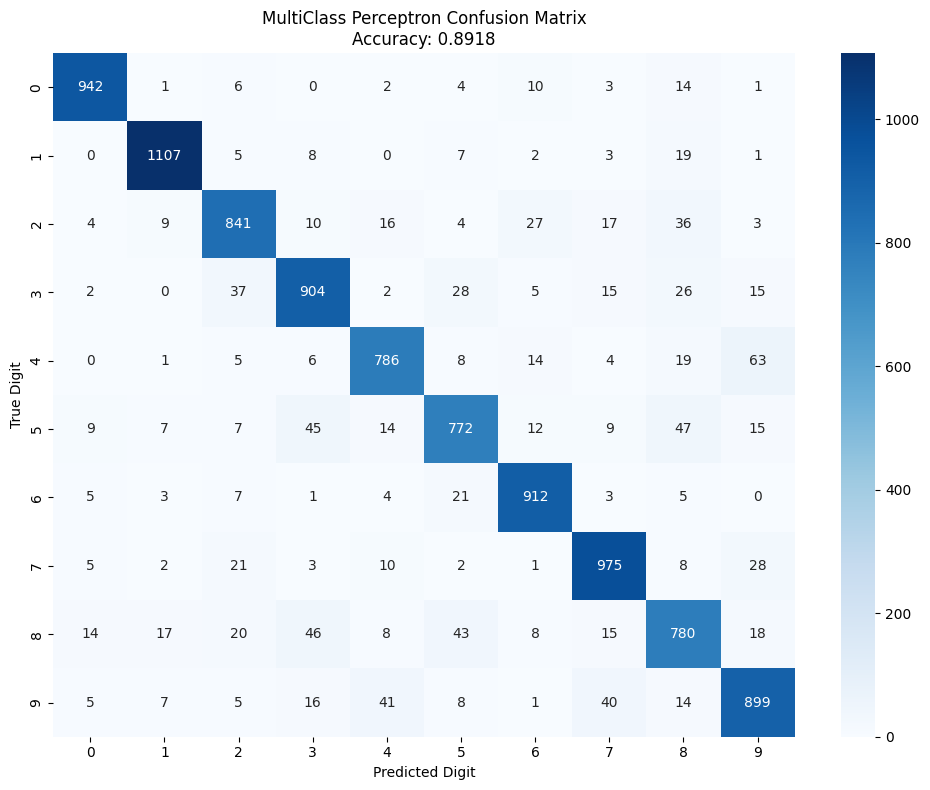

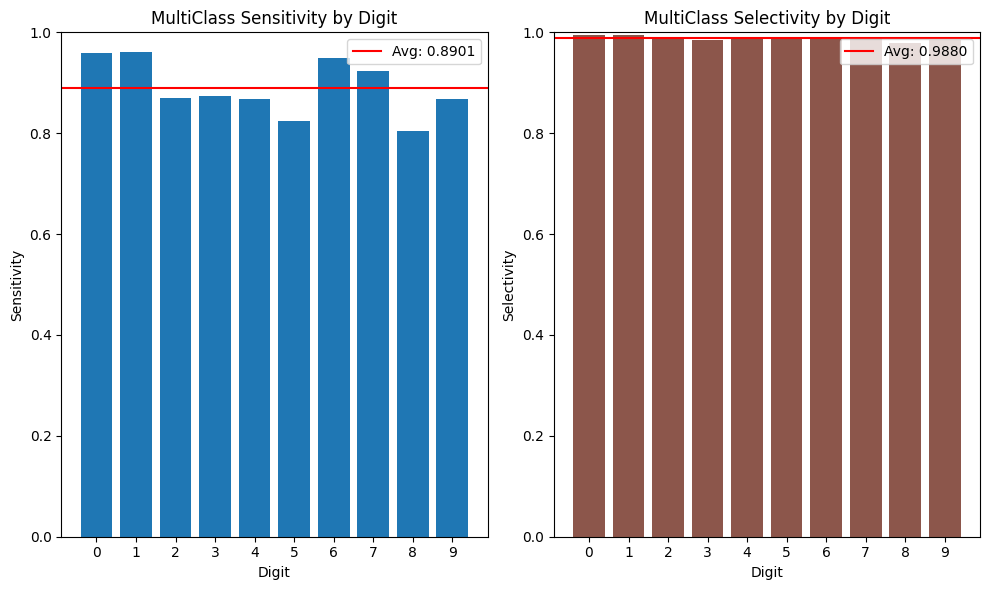

In [ ]:
def train_and_evaluate_multiclass_perceptron(X_train, y_signed_train, X_test, y_test_onehot, max_iterations=700):
    """Train and evaluate multiclass perceptron."""
    print("=== Training MultiClass Perceptron ===")

    # Create and train the MultiClassPerceptron
    model = MultiClassPerceptron(n_features=X_train.shape[1], n_classes=10, max_iterations=max_iterations)
    model.fit(X_train, y_signed_train)

    # Make predictions on test data
    y_pred = model.predict(X_test)
    y_true = np.argmax(y_test_onehot, axis=1)

    # Calculate overall accuracy
    accuracy = np.mean(y_pred == y_true)
    print(f"\nMultiClass Perceptron Accuracy: {accuracy:.4f}")

    # Generate confusion matrix
    conf_matrix = np.zeros((10, 10), dtype=int)
    for i in range(len(y_true)):
        conf_matrix[y_true[i], y_pred[i]] += 1

    # Calculate sensitivity and selectivity for each digit
    sensitivities = np.zeros(10)
    selectivities = np.zeros(10)

    for i in range(10):
        # Sensitivity = TP / (TP + FN)
        # For digit i, TP is conf_matrix[i,i]
        # Sum of row i is all samples that should be classified as i
        sensitivities[i] = conf_matrix[i, i] / np.sum(conf_matrix[i, :]) if np.sum(conf_matrix[i, :]) > 0 else 0

        # Selectivity (TNR) = TN / (TN + FP)
        # For multiclass, this is a bit different:
        # TN = all samples not from class i that were not predicted as i
        # FP = all samples not from class i that were predicted as i
        total_not_i = len(y_true) - np.sum(conf_matrix[i, :])  # All samples not from class i
        false_pos_i = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]  # All predicted as i minus true positives
        true_neg_i = total_not_i - false_pos_i

        selectivities[i] = true_neg_i / total_not_i if total_not_i > 0 else 0

    # Organize metrics
    metrics = {
        'Accuracy': [accuracy] * 10,  # Same accuracy for all digits in multiclass
        'Sensitivity': sensitivities,
        'Selectivity': selectivities
    }

    # Print metrics
    print("\nMetrics for each digit:")
    print("Digit  |  Sensitivity  |  Selectivity")
    print("----------------------------------")
    for digit in range(10):
        print(f"  {digit}    |   {sensitivities[digit]:.4f}   |   {selectivities[digit]:.4f}")

    print(f"\nAverage Sensitivity: {np.mean(sensitivities):.4f}")
    print(f"Average Selectivity: {np.mean(selectivities):.4f}")

    # Visualize results
    plot_multiclass_confusion_matrix(conf_matrix, accuracy)
    plot_multiclass_metrics({'Sensitivity': sensitivities, 'Selectivity': selectivities})

    return model, metrics, conf_matrix

# Running the training and evaluation
model, multiclass_metrics, multiclass_conf_matrix = train_and_evaluate_multiclass_perceptron(X_train, y_signed_train, X_test, y_test_onehot)

---
## **Comparasion and conclusion**
We started by trainining and testing the signle perceptron on each digit individually in a one vs all approach to correctly clasify each digit

In this approach all models are seperated and do not function to predict as wanted, therfore we implement the multi class perceptron:

Training the perceptrons again and determining the best confidence score to determine the class the full model is more sure of in classifying and predicting the data

We can summarize the results of the two models to deduce our insights into the strengths and weaknesses of the multi class model:


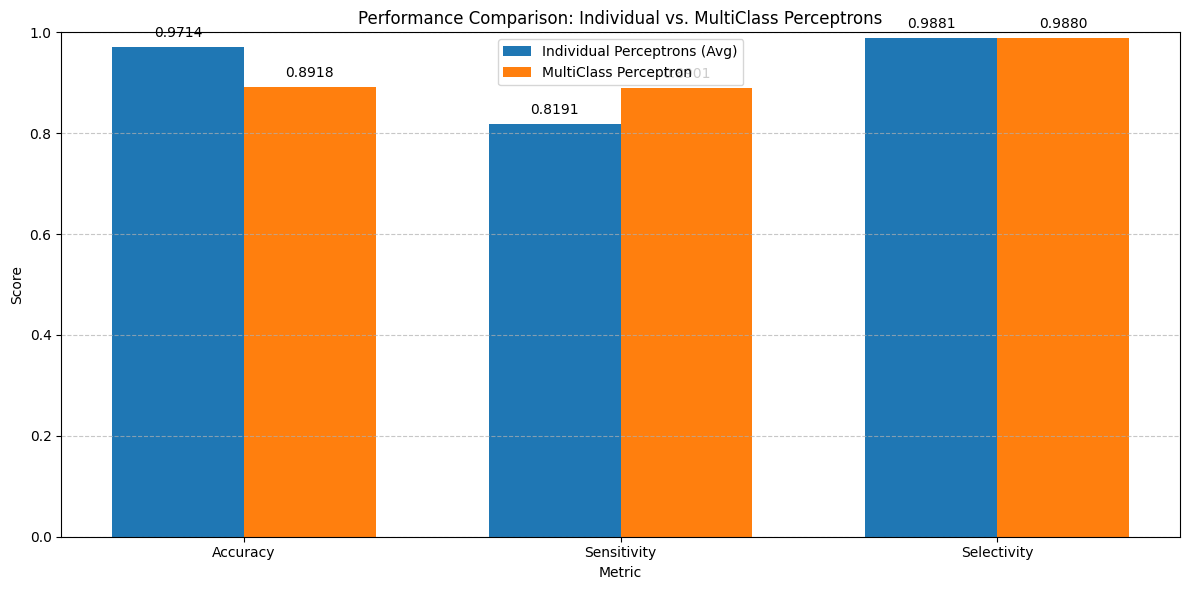

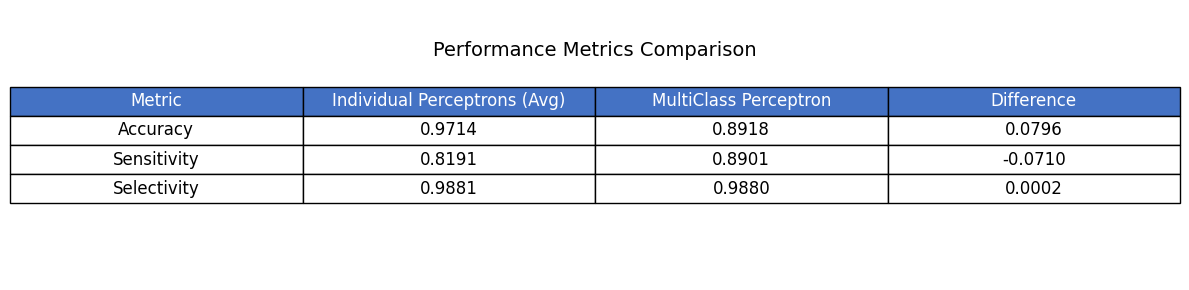

In [ ]:
# Compare the models
compare_models(binary_metrics, multiclass_metrics)

####**Summery of the perceptron descussion**

##### **Accuracy:** Analyzing the data above we can see a major trade off in accuracy when we implement a multi class perceptron. By implementing a perceptron that tries to predict the data by deciding based on the highest confidence score (using the argmax method) the accuracy is reduced greatly (by ~10%-7%) and fails to utilize the potential of the high accuracy achieved by all individual perceptrons.

##### **Limitations of Linear Boundaries:** The 89.18% accuracy (rather than higher) reflects the inherent limitations of perceptrons even with the pocket algorithm, which can only form linear decision boundaries. This suggests some digit classes aren't perfectly linearly separable from others (compared to other models).

##### **High Selectivity scores (TNR):** Very effective at correctly identifying negative cases, resulting in few false positives.

##### **Simplicity:** The rather simple implementation of the perceptron and the multi class perceptron is a positive considering the "alright" results of accuracy we achieve with such a model.

##### **Speed:** Knowing the big trade off we get in accuracy of correctly identified classes - the long running times (7-8m) in training and testing that are needed for the perceptron are too slow knowing the rather low accuracy we are getting.

# **Part B: Softmax Regression**
### **We define the Logistic Regression model class**
* The model utilizes softmax as the activation function to determine the propability in correctly classifying the class in a multi class problem
* We will control the model using two **hyperparameters**: epochs and learning rate(lr)

In [ ]:
class LogisticRegression:
  def __init__(self, input_dim, num_classes, learning_rate=0.1):
    self.input_dim = input_dim
    self.num_classes = num_classes
    self.learning_rate = learning_rate

    self._W = None

    # For tracking performance
    self.train_loss_history = []
    self.test_loss_history = []

  def softmax(self, score):
    # For numerical stability - subtract the row-wise max of exps
    shifted_score = score - np.max(score, axis=1, keepdims=True)

    exp_scores = np.exp(shifted_score)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

  def predict_proba(self, X):
    scores = np.dot(X, self._W)
    return self.softmax(scores)

  def predict(self, X):
    return np.argmax(self.predict_proba(X), axis=1)

  def cross_entropy_loss(self, X, y):
    P_hat = self.predict_proba(X)

    # To avoid log(0) - ensure probabilities are in the range [ε, 1-ε]
    epsilon = 1e-15
    P_hat_clipped = np.clip(P_hat, epsilon, 1 - epsilon)

    # y is one-hot encoded, so multiplying it element-wise is equivalent to I[Yn=k]
    loss = -np.mean(y * np.log(P_hat_clipped))
    return loss

  def compute_gradient(self, X, y):
    # Get predicted probabilities
    P_hat = self.predict_proba(X)

    # Gradient: X^T · (P_hat - y) / n_samples
    error = P_hat - y
    gradient = np.dot(X.T, error) / X.shape[0]

    return gradient

  def fit(self, X_train, y_train, X_test, y_test, epochs=100, verbose=True):
    n_samples = X_train.shape[0]

    # Reset history
    self.train_loss_history = []
    self.test_loss_history = []

    n_features = X_train.shape[1]
    n_classes = self.num_classes

    # Generate weights with normal distribution
    self._W = np.random.normal(0, 0.01, (n_features, n_classes))

    # Truncate extreme values (e.g., beyond 2 standard deviations)
    threshold = 1.5*0.01
    self._W = np.clip(self._W, -threshold, threshold)

    # Initialize progress bar
    for epoch in tqdm(range(epochs), desc="Training with logistic regression"):
      # Compute gradient
      gradient = self.compute_gradient(X_train, y_train)

      # Update weights
      self._W -= self.learning_rate * gradient

      # Compute loss on training and test data
      train_loss = self.cross_entropy_loss(X_train, y_train)
      test_loss = self.cross_entropy_loss(X_test, y_test)

      # Record losses
      self.train_loss_history.append(train_loss)
      self.test_loss_history.append(test_loss)

      # Print progress
      if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Compute confusion matrix for final evaluation
    confusion_matrix = self.compute_confusion_matrix(X_test, y_test)

    return self.train_loss_history, self.test_loss_history, confusion_matrix

  def compute_confusion_matrix(self, X, y_onehot):
      # Convert one-hot encoded labels to indices
      y_true = np.argmax(y_onehot, axis=1)

      # Get predictions
      y_pred = self.predict(X)

      # Initialize confusion matrix
      conf_matrix = np.zeros((self.num_classes, self.num_classes), dtype=int)

      # Fill confusion matrix
      for i in range(len(y_true)):
          conf_matrix[y_true[i], y_pred[i]] += 1

      return conf_matrix

  def compute_metrics(self, confusion_matrix):
    # Calculate accuracy
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Calculate sensitivity (recall) for each class
    sensitivity = np.zeros(self.num_classes)
    for i in range(self.num_classes):
        sensitivity[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[i, :])

    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity
    }

  def plot_loss_history(self):
    plt.figure(figsize=(10, 6))
    plt.plot(self.train_loss_history, label='Training Loss')
    plt.plot(self.test_loss_history, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.title('Loss over epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

  def plot_confusion_matrix(self, confusion_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(self.num_classes),
                yticklabels=range(self.num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

  def get_W(self):
    return self._W

###**Running the model**
We run the model by initializing it and running the fit function to train it based on out analysis of the efficiency of these specific hyperparameters (See next part):
* The learning rate is set to **1**
* The number of epochs is selected to be **450** (Altough it's considered overkill)

Training with logistic regression:   0%|          | 0/450 [00:00<?, ?it/s]

Final Accuracy: 0.9167


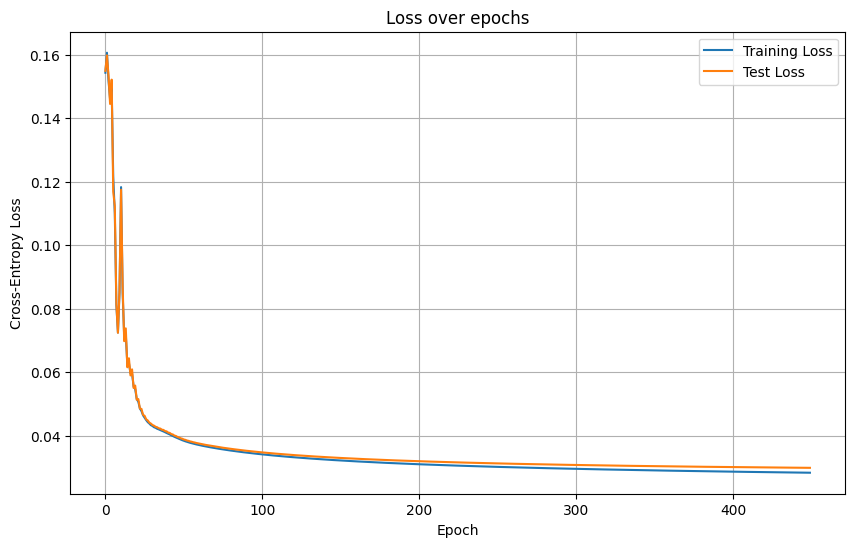

In [32]:
# Create and train the model
model = LogisticRegression(
    input_dim=X_train.shape[1],
    num_classes=10,
    learning_rate=1
)

# Train with mini-batch gradient descent
train_loss, test_loss, conf_matrix = model.fit(
    X_train, y_train_onehot,
    X_test, y_test_onehot,
    epochs=450,
    verbose=False
)

# Evaluate and visualize results
metrics = model.compute_metrics(conf_matrix)
print(f"Final Accuracy: {metrics['accuracy']:.4f}")
model.plot_loss_history()

### **Choosing the hyperparameters**
* **Learning rate** - To determine the best learning rate to use for our model in training I've ran the testing with different learning rates to see which lr would return the best loss function over epochs, we look for a smooth and fast convergence, by analyzing the graph we select **lr=1**.
* **Epochs** - Simillarly to the lr, to decide on the right amount of epochs to save resources and imrpove running time, we can analyze the same graph to see that after a number of epochs the graph seems to converge and the model hardly improves. By looking closly we can pick the number of epochs to be **~175** (I choose **450** to maximize results to easier prove our point in the conclusions part (Altough with our analysis it would be way samrter to go with ~200 epochs).

In [35]:
def compare_learning_rates(X_train, y_train, X_test, y_test, epochs=200):
    """
    Compare different learning rates by training models and plotting their loss curves.
    """
    # Define learning rates to test
    learning_rates = [1, 0.5, 0.1, 0.01, 0.01, 1e-4, 1e-5, 5e-4]

    # Dictionary to store results
    results = {}

    # Set up the plot
    plt.figure(figsize=(15, 10))

    # Train a model for each learning rate
    for lr in learning_rates:
        print(f"\nTraining with learning rate: {lr}")

        # Initialize model with current learning rate
        model = LogisticRegression(
            input_dim=X_train.shape[1],
            num_classes=y_train.shape[1],
            learning_rate=lr
        )

        # Train the model
        train_loss, test_loss, conf_matrix = model.fit(
            X_train, y_train,
            X_test, y_test,
            epochs=epochs,
            verbose=False
        )

        # Store the model and its results
        results[lr] = {
            'model': model,
            'train_loss': train_loss,
            'test_loss': test_loss,
            'conf_matrix': conf_matrix
        }

        # Calculate final accuracy
        metrics = model.compute_metrics(conf_matrix)
        accuracy = metrics['accuracy']

        # Plot training loss
        plt.plot(train_loss, label=f'LR: {lr:.1e} (Acc: {accuracy:.4f})')

        # Print summary
        print(f"Learning rate: {lr:.1e}, Final accuracy: {accuracy:.4f}")

    # Add details to plot
    plt.title('Training Loss Comparison for Different Learning Rates')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

    return results


Training with learning rate: 1


Training with logistic regression:   0%|          | 0/200 [00:00<?, ?it/s]

Learning rate: 1.0e+00, Final accuracy: 0.9119

Training with learning rate: 0.5


Training with logistic regression:   0%|          | 0/200 [00:00<?, ?it/s]

Learning rate: 5.0e-01, Final accuracy: 0.9050

Training with learning rate: 0.1


Training with logistic regression:   0%|          | 0/200 [00:00<?, ?it/s]

Learning rate: 1.0e-01, Final accuracy: 0.8763

Training with learning rate: 0.01


Training with logistic regression:   0%|          | 0/200 [00:00<?, ?it/s]

Learning rate: 1.0e-02, Final accuracy: 0.8045

Training with learning rate: 0.01


Training with logistic regression:   0%|          | 0/200 [00:00<?, ?it/s]

Learning rate: 1.0e-02, Final accuracy: 0.8072

Training with learning rate: 0.0001


Training with logistic regression:   0%|          | 0/200 [00:00<?, ?it/s]

Learning rate: 1.0e-04, Final accuracy: 0.1734

Training with learning rate: 1e-05


Training with logistic regression:   0%|          | 0/200 [00:00<?, ?it/s]

Learning rate: 1.0e-05, Final accuracy: 0.0868

Training with learning rate: 0.0005


Training with logistic regression:   0%|          | 0/200 [00:00<?, ?it/s]

Learning rate: 5.0e-04, Final accuracy: 0.4147


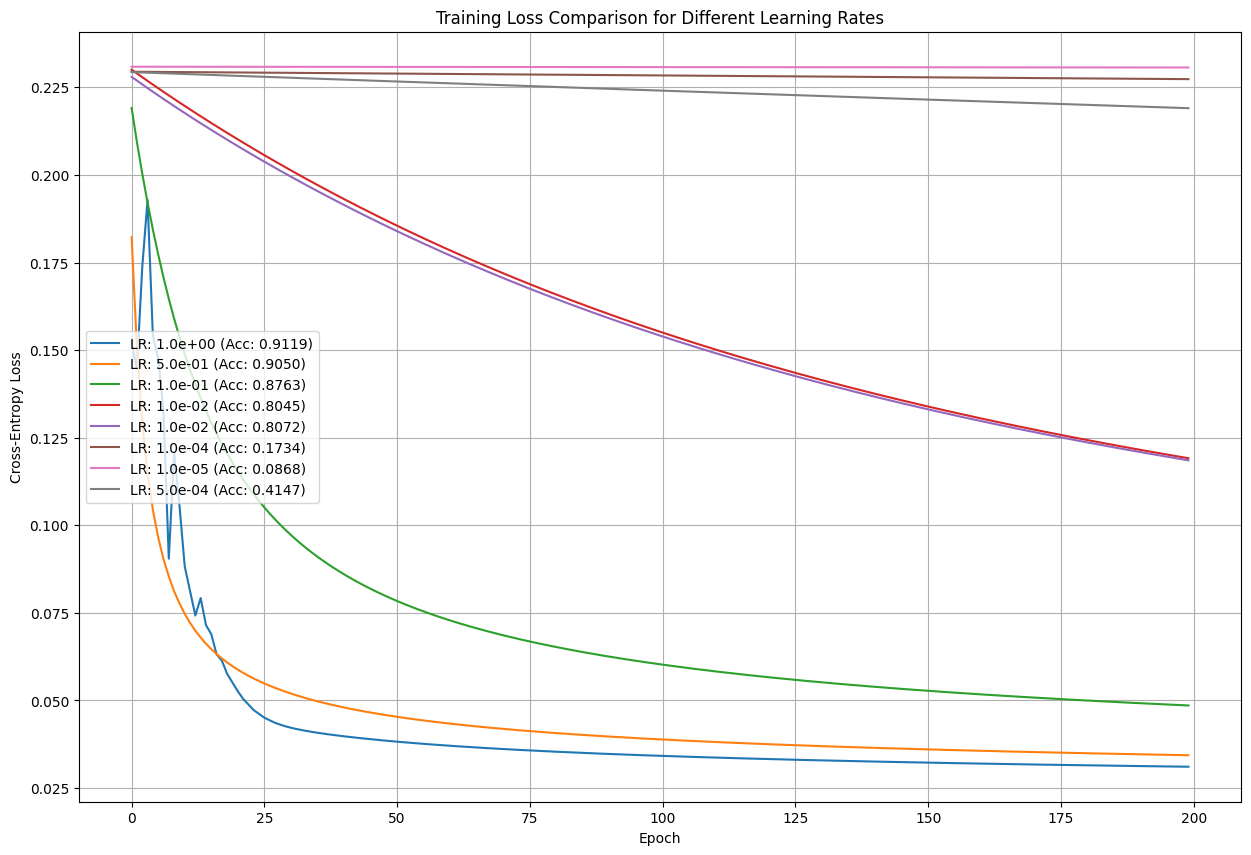


Best learning rate: 1


In [43]:
# Run the comparison
results = compare_learning_rates(
    X_train, y_train_onehot,
    X_test, y_test_onehot,
    epochs=200
)

# Access the best model (if needed)
# First, find the learning rate with the highest accuracy
best_lr = max(results.keys(), key=lambda lr:
              results[lr]['model'].compute_metrics(results[lr]['conf_matrix'])['accuracy'])

print(f"\nBest learning rate: {best_lr}")
best_model = results[best_lr]['model']

# You can now use best_model for predictions, visualization, etc.
best_conf_matrix = results[best_lr]['conf_matrix']

**Looking at the results above we can see that higher learning rates performed better for the model so we select lr = 1**

---
### **Analyzing the model**
**After training the model with logistic regression we can closely analyze our model's performance by looking at the confusion matrix of the whole model and of each digit on its own as well as the accuracy scores we achieved.**

The below results will be our basis for the summary and conclusions of the tests.

Overall Accuracy: 0.9167

Accuracy for each digit:
Digit 0: 0.9613
Digit 1: 0.9679
Digit 2: 0.8956
Digit 3: 0.8946
Digit 4: 0.9260
Digit 5: 0.8719
Digit 6: 0.9490
Digit 7: 0.9355
Digit 8: 0.8545
Digit 9: 0.9006

Sensitivity (TPR) for each digit:
Digit 0: 0.9613
Digit 1: 0.9679
Digit 2: 0.8956
Digit 3: 0.8946
Digit 4: 0.9260
Digit 5: 0.8719
Digit 6: 0.9490
Digit 7: 0.9355
Digit 8: 0.8545
Digit 9: 0.9006

Precision for each digit:
Digit 0: 0.9623
Digit 1: 0.9425
Digit 2: 0.9040
Digit 3: 0.8826
Digit 4: 0.9080
Digit 5: 0.8939
Digit 6: 0.9316
Digit 7: 0.9311
Digit 8: 0.8865
Digit 9: 0.9165


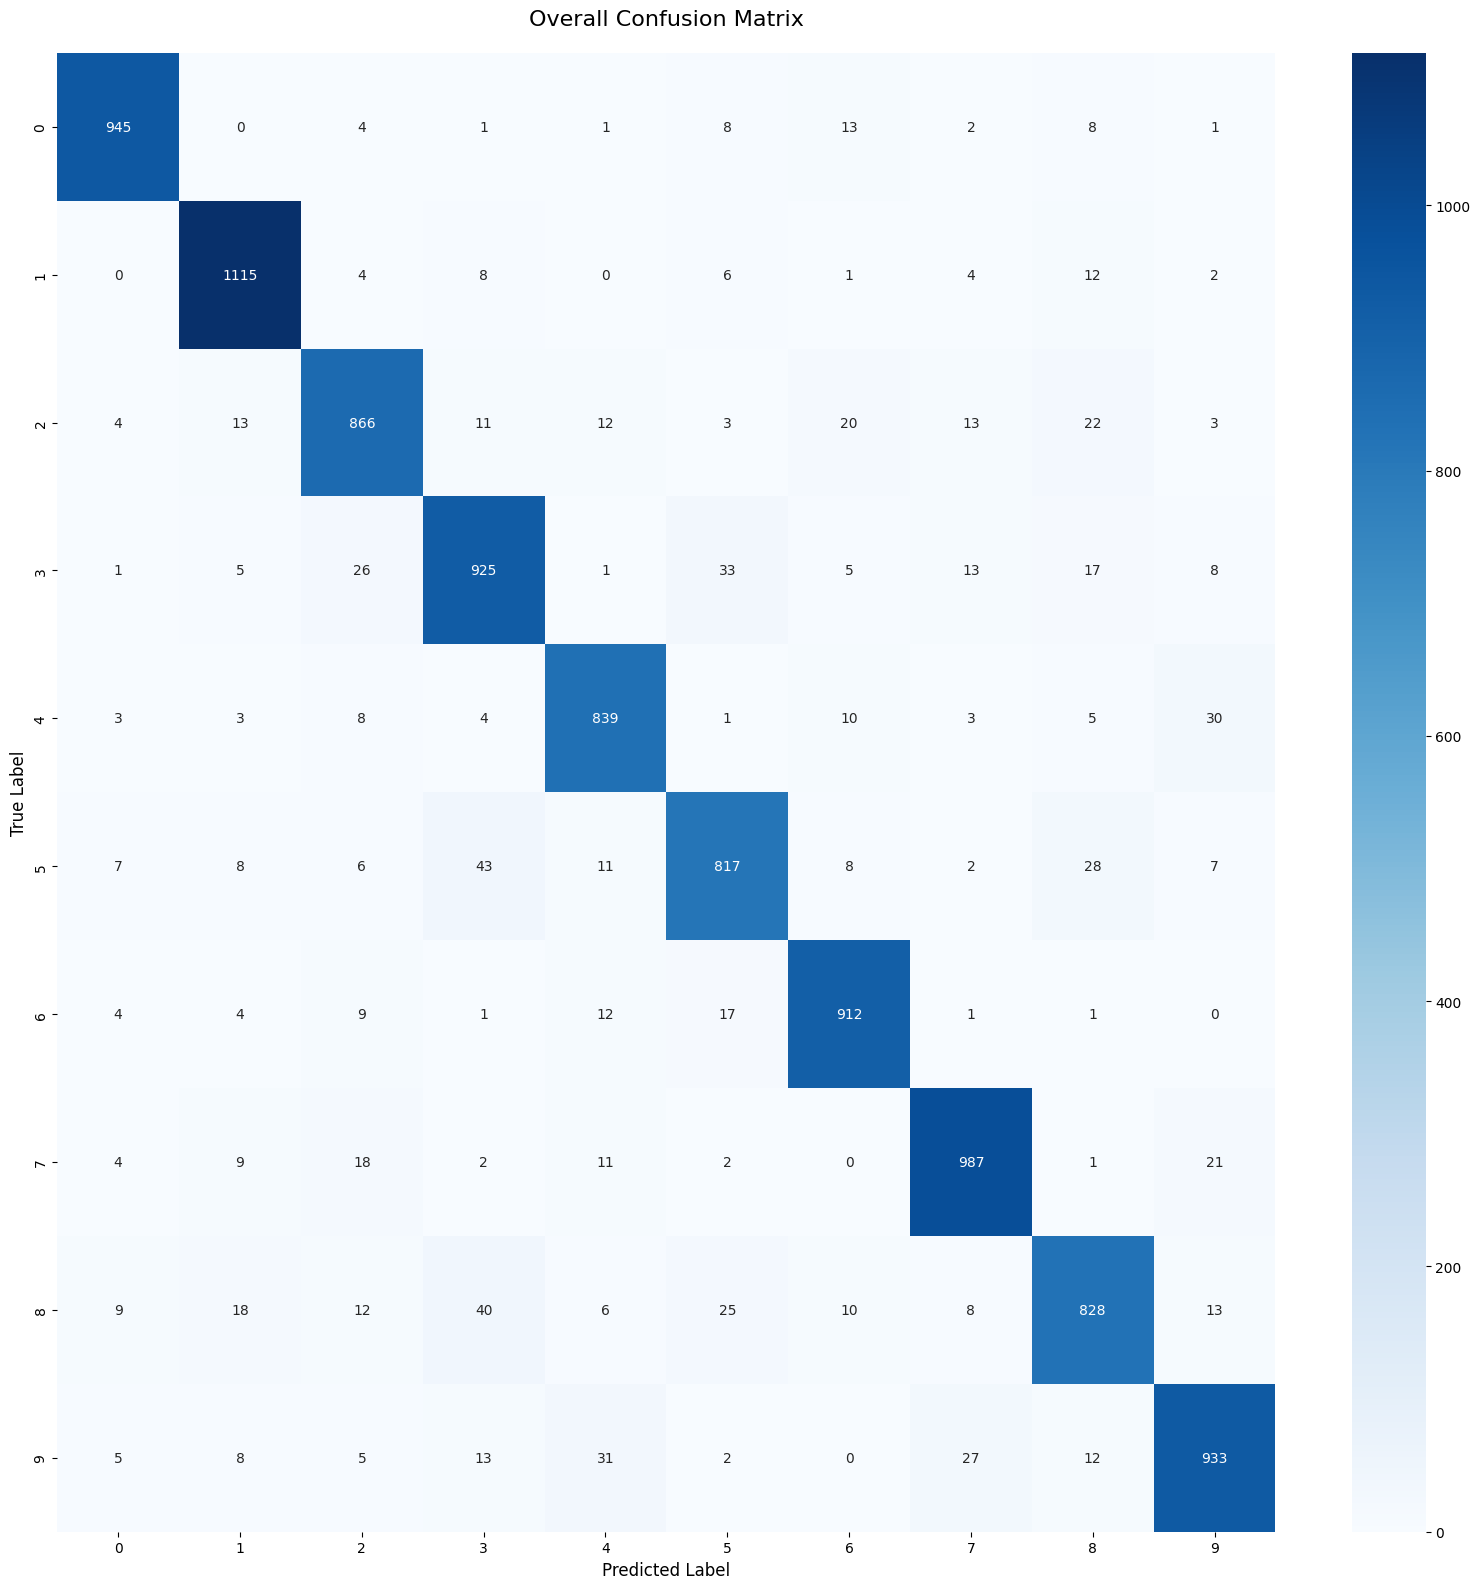

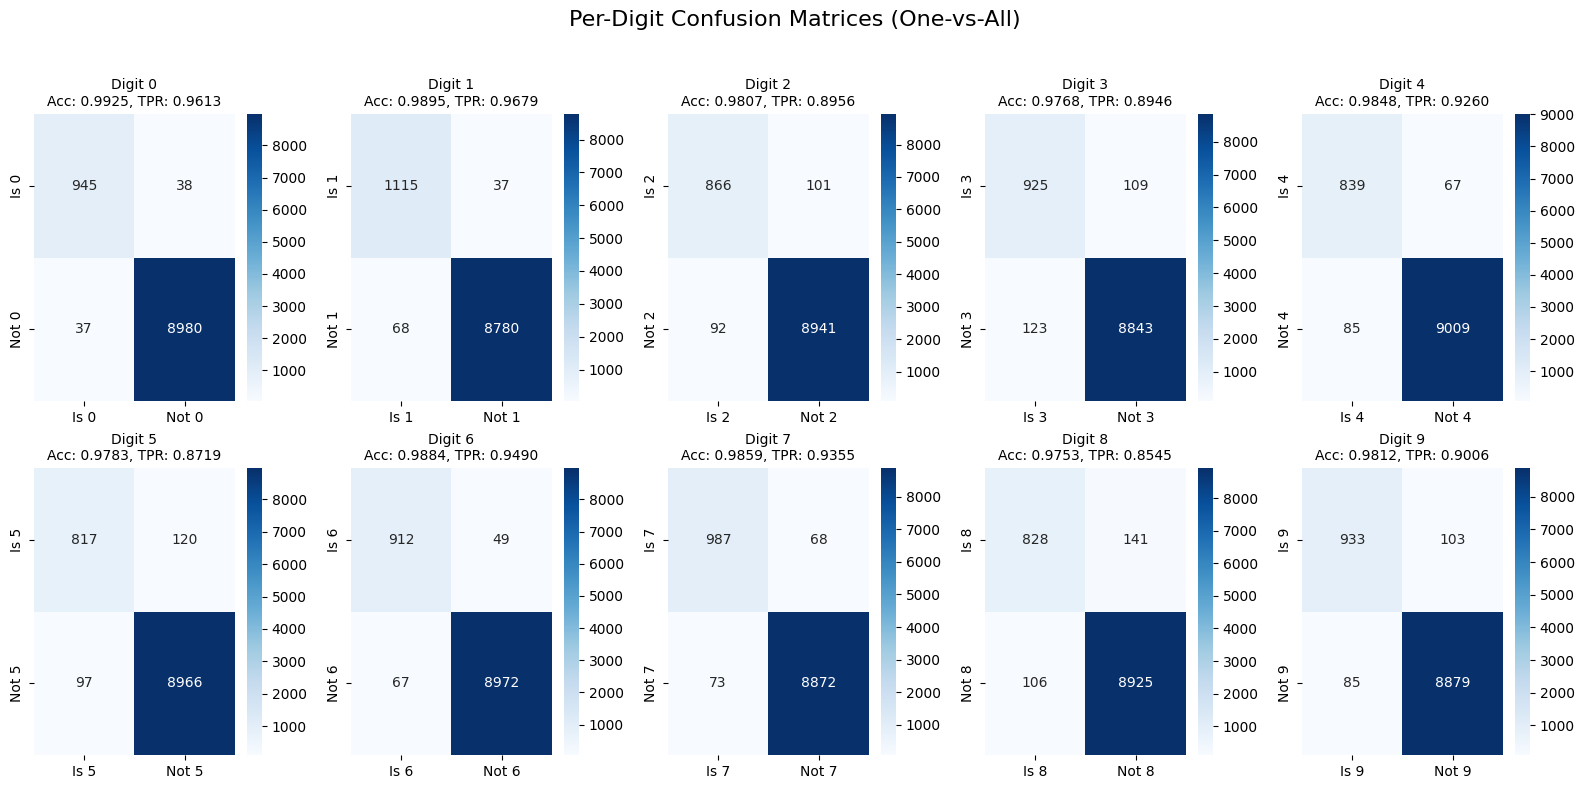

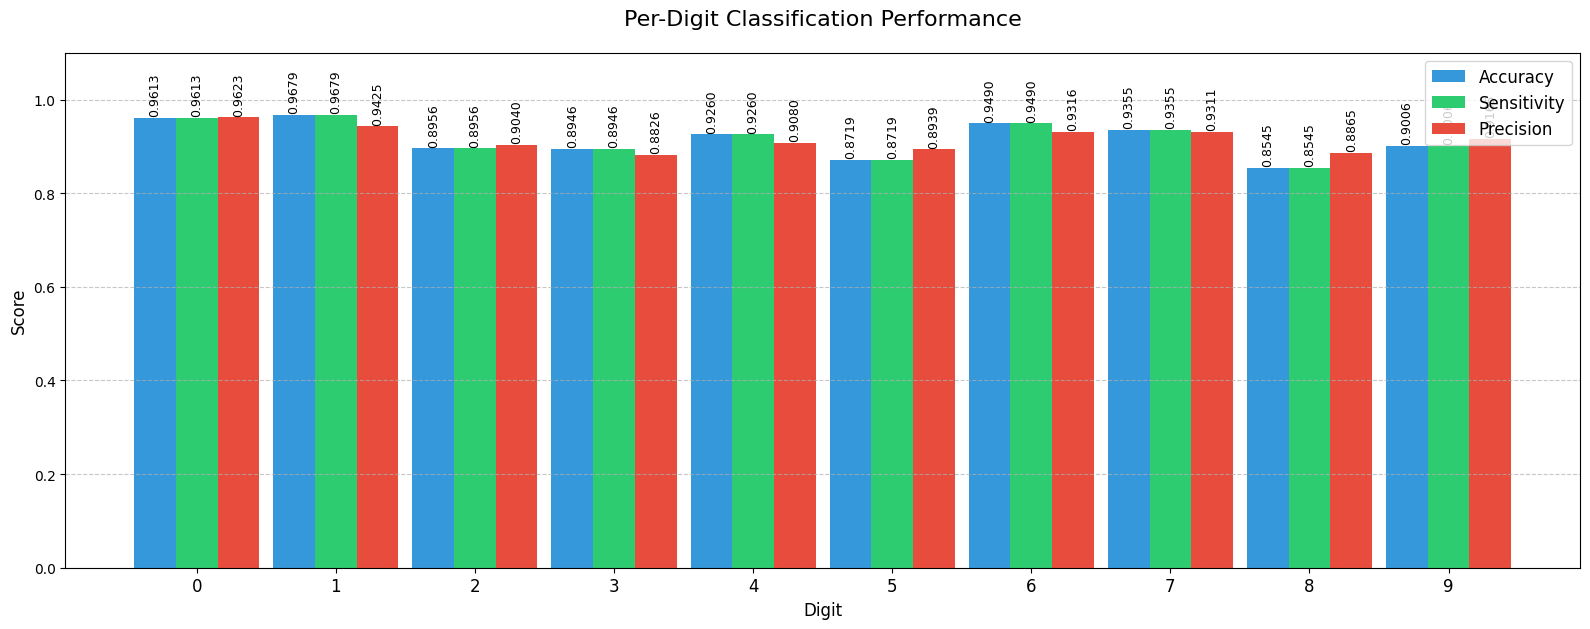

In [42]:
# Run the analysis
metrics = analyze_classification_performance(model, X_test, y_test_onehot)

---
## **Comparasion and conclusion**
After training our model this time using the logistic regression with the softmax activation function we are ready to conclude the main evaluations:
* **Accuracy** - This time (compared to the perceptron) we have managed to reach a better accuracy of ~91% after tweaking different hyperparameters to achieve the best results.
* **Speed** - The model performes great in terms of speed by managing to train itself relatively quickly and better to get adequate results (running at rougly 3 mins compared to the perceptron which ran for 8 min).
* **Balance metrics** - The close alignment between accuracy, sensitivity, and precision for each digit indicates the model makes consistent predictions without significant bias toward specific digits. The high precision values (especially for digits 0, 1, 7, 9) indicate minimal false positives, suggesting good generalization rather than overfitting.
* **Learning Rate Optimization** - The observation that higher learning rates lead to better convergence is noteworthy. This suggests the loss landscape for this problem allows for larger optimization steps without overshooting.